In [1]:
import os
import time
import numpy as np
import graphs
import pandas
import tkinter 
import matplotlib.pyplot as plt
import matplotlib.colors as mc

from tqdm import tqdm
from tkinter import filedialog
from tkinter.filedialog import askopenfilenames
from matplotlib.colors import TwoSlopeNorm


In [2]:
### Function to create 2 or 4 array subplot 
def arraygraph(sensor, sensorflatten, sensorfilter, sensorfilterflatten, hotpixerror, name):
    ### if a hot pixel is detected show 4 plots (sensor array, flattened sensor array, filtered sensor array, flattened filtered sensor array)
    if hotpixerror == 1:
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 4))                 # Set subplot amount 2x2

        ### Plot first subplot
        im = axes[0,0].imshow(sensor, cmap='bwr', interpolation='nearest')          # set color for plot
        axes[0,0].set_xlabel('Pixels X')                                            # x label
        axes[0,0].set_ylabel('Pixels Y')                                            # y label
        axes[0, 0].invert_yaxis()                                                   # invert y axis 
        axes[0,0].set_title('Pre-filtered sensor array ' + str(name))               # title
        fig.colorbar(im, ax=axes[0, 0])                                             # add colourbar
        ### Plot second subplot
        x = np.arange(sensorflatten.shape[0])                                       # flatten sensor 
        axes[0, 1].plot(x, sensorflatten)                                           # plot sensor pixel count along flattened axis 
        axes[0, 1].set_xlabel('Position')                                           # x label
        axes[0, 1].set_ylabel('Value')                                              # y label
        axes[0, 1].set_title('Flattened Pre-filtered sensor ' + str(name))          # title
        ### Plot third subplot
        im2 = axes[1, 0].imshow(sensorfilter, cmap='bwr', interpolation='nearest')  # set color for plot
        axes[1, 0].set_xlabel('Pixels X')                                           # x label
        axes[1, 0].set_ylabel('Pixels Y')                                           # y label
        axes[1, 0].invert_yaxis()                                                   # invert y axis 
        axes[1, 0].set_title('Post-filtered sensor array ' + str(name))             # title
        fig.colorbar(im2, ax=axes[1, 0])                                            # add colourbar
        ### Plot fourth subplot
        x2 = np.arange(sensorfilterflatten.shape[0])                                # flatten sensor 
        axes[1, 1].plot(x2, sensorfilterflatten)                                    # plot filtered sensor pixel count along flattened axis 
        axes[1, 1].set_xlabel('Position')                                           # x label
        axes[1, 1].set_ylabel('Value')                                              # y label
        axes[1, 1].set_title('Flattened Post-filtered sensor ' + str(name))         # title
    else:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))                 # Set subplot amount 1x2

        ### Plot first subplot
        im = axes[0].imshow(sensor, cmap='bwr', interpolation='nearest')            # set color for plot
        axes[0].set_xlabel('Pixels X')                                              # x label
        axes[0].set_ylabel('Pixels Y')                                              # y label
        axes[0].invert_yaxis()                                                      # invert y axis 
        axes[0].set_title('Pre-filtered sensor array ' + str(name))                 # title
        fig.colorbar(im, ax=axes[0])                                                # add colourbar
        ### Plot second subplot
        x = np.arange(sensorflatten.shape[0])                                       # flatten sensor
        axes[1].plot(x, sensorflatten)                                              # plot sensor pixel count along flattened axis 
        axes[1].set_xlabel('Position')                                              # x label
        axes[1].set_ylabel('Value')                                                 # y label
        axes[1].set_title('Flattened Pre-filtered sensor ' + str(name))             # title
        
    plt.tight_layout()                                                              # Adjust spacing between subplots
    plt.show()                                                                      # Display the figure

In [3]:
### function to detect if hot pixels are present 
def hotpixdetector(Ncsv, name):    
    ### Variables
    t=30                                                    # time in seconds to prevent large files from running overtime
    sensor = np.zeros((720, 1280))                          # sensor array
    sensorflatten = sensor.flatten()                        # flattened sensor array
    sensorfilter = np.zeros((720, 1280))                    # filtered sensor array
    sensorfilterflatten = sensorfilter.flatten()            # flattened filtered sensor array
    position = []                                           # hot pixel position array
    hotpixerror = 0                                         # hot pixel error flag
    st = time.time()                                        # start time for loop
    
    ### loop to start loading events into the sensor array either until t is reached or file finished whatever comes first
    for i in range(1,len(Ncsv['t'])):
        if (time.time()-st) > t:                            # check current runtime against user specified time
            break                                           # if runtime exceeded break from loop
        elif Ncsv['on'][i] == 1:                            # if event is 1/True
            x=Ncsv['x'][i]                                  # load x location
            y=Ncsv['y'][i]                                  # load y location
            sensor[y,x] += 1                                # add 1 to x,y position in array
        elif Ncsv['on'][i] == 0:                            # if event is 0/False
            x=Ncsv['x'][i]                                  # load x location
            y=Ncsv['y'][i]                                  # load y location
            sensor[y,x] -= 1                                # minus 1 to x,y position in array

    sensorflatten = sensor.flatten()                        # fill flattened sensor array
    meansensorflattened = np.mean(sensorflatten)            # mean value of flattened sensor
    maxsensorflattened = max(sensorflatten)                 # max value of flattened sensor
    minsensorflattened = min(sensorflatten)                 # min value of flattened sensor

    ### Loop to determin if hot pixels evident. check if min or max is a user defined % away form the mean
    if abs(min(sensorflatten))*0.0025 > abs(meansensorflattened) or abs(max(sensorflatten)) * 0.0025 > abs(meansensorflattened):
        
        ### floor is the boundary of what is the expected norm. if grear than floor assume hot pixel
        if maxsensorflattened >= abs(minsensorflattened):   # determin if max is greater than the absolute of min
            floor = maxsensorflattened * 0.75               # set floor 
        elif maxsensorflattened < abs(minsensorflattened):  # determin if absolute of min is greater than max
            floor = abs(minsensorflattened) * 0.75          # set floor
        map1 = sensor > floor * (-1)                        # find all values where sensor pixels are greater than neg floor
        map2 = sensor < floor                               # find all vaules where sensor pixels are less than floor
        sensorfilter = map1.astype(int) * map2.astype(int)  # multiple map1 and map2 to return bool filtered snesor
        position = np.argwhere(sensorfilter == 0)           # find all zero positions (hot pixels)
        sensorfilter = sensorfilter * sensor                # multiply sensor and sensor filter to restore non hot pixel values
        sensorfilterflatten = sensorfilter.flatten()        # fill filtered fallened sensor array

        print('Hot Pixel')                                  # print hot pixel to terminal
        hotpixerror = 1                                     # set flag
    else:
        print('No Hot Pixel')                               # print no hot pixel to terminal                                   

    ### Send data to arraygraph function
    arraygraph(sensor, sensorflatten, sensorfilter, sensorfilterflatten, hotpixerror, name)

In [4]:
def timesurface(Ncsv, name):
    ### Variables 
    surfacearray = np.zeros((900, 1400))                                    # set surface array size, note larger than sensor to allow shift
    speed = 3000                                                            # mm/min
    speed_time = speed / 6e7                                                # conversion from mm/min to mm/us
    frame_viewy = 259                                                       # frame_view y in mm
    pix_y = 720                                                             # pixels y axis sensor
    mm_pix = pix_y/frame_viewy                                              # mm/pix 
    shift = speed_time * mm_pix                                             # pix/us y axis shift
    speedx = -250                                                           # speed x axis, this was to allow for error in mechinism as not 100% square
    speed_time_x = speedx/6e7                                               # conversion from mm/min to mm/us x axis
    pix_x = 1280                                                            # pixels x axis sensor
    frame_viewx =  (pix_y/frame_viewy)*pix_x                                # frame_view x in mm
    mm_pix_x = pix_x/frame_viewx                                            # mm/pix 
    shiftx = speed_time_x * mm_pix_x                                        # pix/us x axis shift

    ### iterate over length of csv file, tqdm module used to display a progress bar
    for i in tqdm(range(1,len(Ncsv['t']))):
        if Ncsv['on'][i] == False:                                          # check if event is 0/False
            t=Ncsv['t'][i]                                                  # record time
            x=Ncsv['x'][i]                                                  # record x
            y=Ncsv['y'][i] +200                                             # record y, add 200 (user defined) to shift objects of interest more into array
            yc = abs(round(y-(shift*t)))                                    # determine actual y location accounting for shift
            xc = abs(round(x-(shiftx*t)))                                   # determine actual x location accounting for shift
            
            while yc >= surfacearray.shape[0]:                              # check if actual y is in bounds of array, if not
                new_row = np.zeros((5, surfacearray.shape[1]))              # build 5 new rows to match current column shape of array 
                surfacearray = np.append(surfacearray, new_row, axis=0)     # join surfacearray and new rows

            while xc >= surfacearray.shape[1]:                              # check if actual y is in bounds of array, if not
                new_columns = np.zeros((surfacearray.shape[0], 5))          # build 5 new columns to match current rows shape of array 
                surfacearray = np.append(surfacearray, new_columns, axis=1) # join surfacearray and new columns

            surfacearray[yc,xc] -= 1                                        # minus 1 from actual x,y location

        if Ncsv['on'][i] == True:                                           # check if event is 1/True
            t=Ncsv['t'][i]                                                  # record time
            x=Ncsv['x'][i]                                                  # record x
            y=Ncsv['y'][i] +200                                             # record y, add 200 (user defined) to shift objects of interest more into array
            yc = abs(round(y-(shift*t)))                                    # determine actual y location accounting for shift
            xc = abs(round(x-(shiftx*t)))                                   # determine actual x location accounting for shift
            
            while yc >= surfacearray.shape[0]:                              # check if actual y is in bounds of array, if not
                new_row = np.zeros((5, surfacearray.shape[1]))              # build 5 new rows to match current column shape of array 
                surfacearray = np.append(surfacearray, new_row, axis=0)     # join surfacearray and new rows

            while xc >= surfacearray.shape[1]:                              # check if actual y is in bounds of array, if not
                new_columns = np.zeros((surfacearray.shape[0], 5))          # build 5 new columns to match current rows shape of array 
                surfacearray = np.append(surfacearray, new_columns, axis=1) # join surfacearray and new columns

            surfacearray[yc,xc] += 1                                        # add 1 from actual x,y location

    norm = TwoSlopeNorm(vcenter=0)                                          # create norm to center colour plot at middle of cmap
    plt.clf()                                                               # clear any open figures
    plt.imshow(np.flip(surfacearray, axis=1), cmap='bwr', interpolation='gaussian', norm=norm)
                                                                            # LINE ABOVE - set up array plot
    plt.gca().invert_yaxis()                                                # invert X Axis 
    plt.colorbar()                                                          # add a colorbar to indicate the data range
    plt.title("Timesurface " + str(name) )                                  # title
    plt.xlabel('Pixels (X)', fontsize=12, fontweight='bold')                # x label
    plt.ylabel('Pixels (Y)', fontsize=12, fontweight='bold')                # y label
    plt.show()                                                              # Display the plot                                  


In [5]:
### function to filter high count (hot pixels) from csv
def hotpixfilter(Ncsv):
    print(len(Ncsv))                                                            # display length of csv in terminal
    search = Ncsv.head(1000)                                                    # select first 1000 rows of csv
    row_count = search.groupby(['x', 'y']).size().reset_index(name='count')     # count rows that have common x and y locations (1000 rows)
    row_count = row_count.sort_values(by='count', ascending=False)              # sort count decending 
    filtered_row_count = row_count[row_count['count'] > 1]                      # find all locations that have more than 1 count
    Ncsv = Ncsv[~Ncsv.set_index(['x', 'y']).index.isin(filtered_row_count.set_index(['x', 'y']).index)].reset_index(drop=True) 
                                                                                # LINE ABOVE - keep rows in csv file by x,y location that do not match filtered rows reset index for iteration loops 


    row_count = Ncsv.groupby(['x', 'y']).size().reset_index(name='count')       # count rows that have common x and y locations (whole csv)
    row_count = row_count.sort_values(by='count', ascending=False)              # sort count decending 
    filtered_row_count = row_count[row_count['count'] > (len(Ncsv)*0.00005)]    # find all locations that have more counts than the total events multiplied by 0.005%
    Ncsv = Ncsv[~Ncsv.set_index(['x', 'y']).index.isin(filtered_row_count.set_index(['x', 'y']).index)].reset_index(drop=True)
                                                                                # LINE ABOVE - keep rows in csv file by x,y location that do not match filtered rows reset index for iteration loops
    print(len(Ncsv))                                                            # display length of filtered csv in terminal

    return Ncsv                                                                 # return new csv 
    


In [6]:
### file and path to csv 
cf = 'G:\\PG\\WorkingFolderV2\\Recording_originals\\Off\\v3rec17-08-2023\\T_ADJ\\off_48_on_255_T4to7.csv'
#cf = 'G:\\PG\\WorkingFolderV2\\Recording_originals\\On\\v2rec17-08-2023\\TimeADJ\\off_255_on_50_T4to7.csv'

name = os.path.basename(cf)      # Get file name
name = name[:-10]               # Remove unwanted characters from selected file name can adjust or comment out

Ncsv =  pandas.read_csv(cf)     # 1st csv to remain unmodified
Ncsv2 = Ncsv                    # 2nd csv used for filtering

Hot Pixel


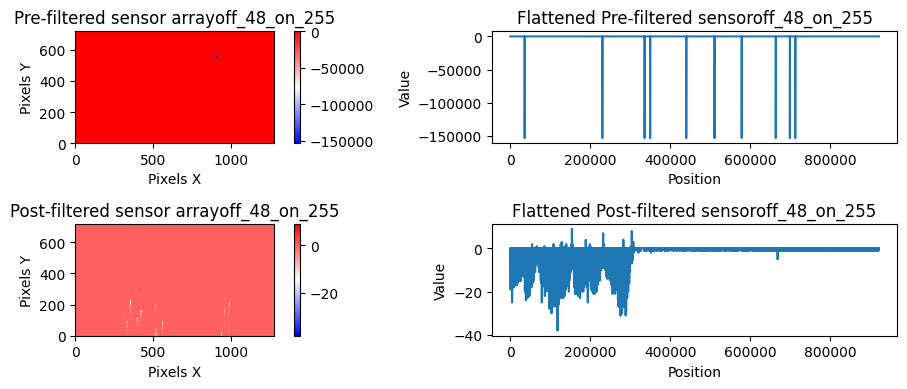

In [7]:
hotpixdetector(Ncsv, name)

In [8]:
timesurface(Ncsv, name)

 25%|██▌       | 6977371/27783642 [03:30<10:28, 33128.62it/s]

In [ ]:
Ncsv2 = hotpixfilter(Ncsv2)

In [ ]:
hotpixdetector(Ncsv2)

In [ ]:
timesurface(Ncsv2, name)